In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2

In [23]:
from keras.preprocessing import image

In [24]:
train_images = sorted(os.listdir('/kaggle/input/indian-license-plates/in/in'))

In [25]:
train_image = []
for im in train_images:
    img = image.load_img('/kaggle/input/indian-license-plates/in/in/'+ im, target_size=(64,64), color_mode= 'grayscale')
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
train_df = np.array(train_image)

### Defining a plot function

In [26]:
import matplotlib.pyplot as plt

def show_img(dataset):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(40, 20)
    for i in range(5,10):
        ax[i-5].imshow(dataset[i].reshape(64,64), cmap='gray')
    plt.show()

### Defining a function for Noice addition. 0.07 is multiplied as it is the fraction of noice that we want in our picture.

In [27]:
def add_noice(image):
    row,col,ch= image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss*0.07
    return noisy

In [28]:
noised_df= []

for img in train_df:
    noisy= add_noice(img)
    noised_df.append(noisy)

In [29]:
noised_df= np.array(noised_df)

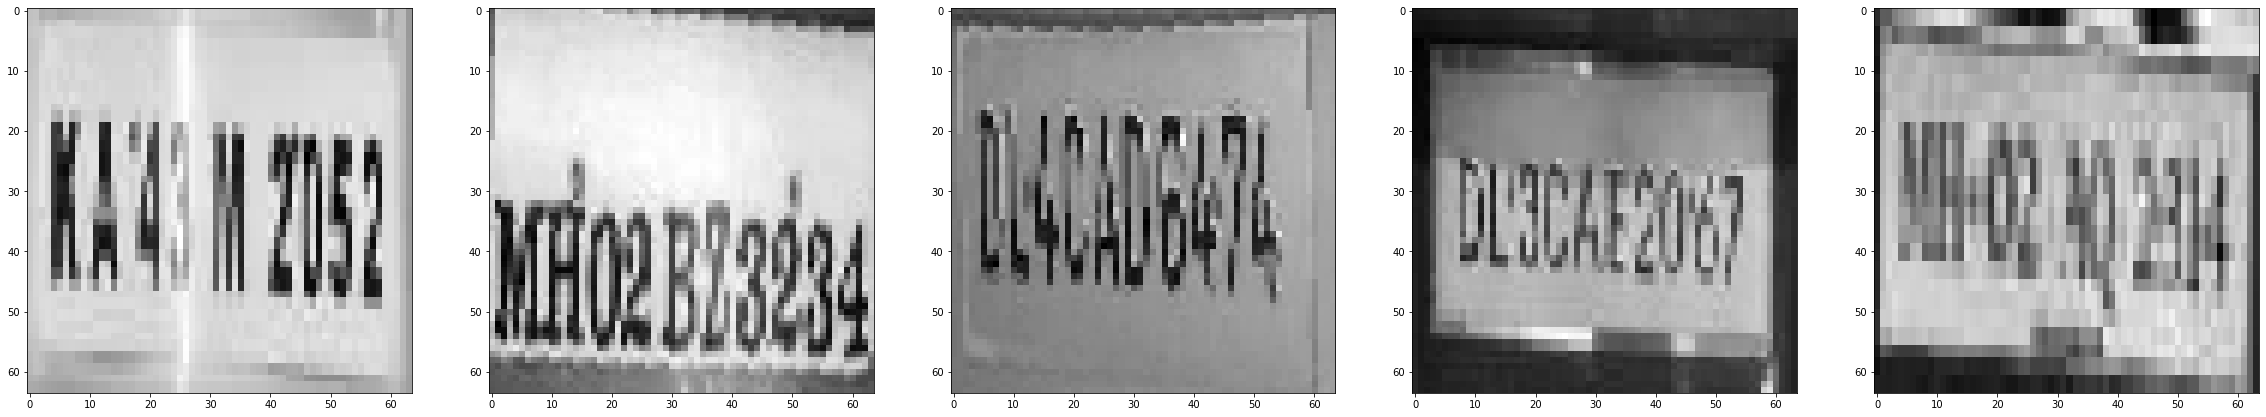

In [30]:
show_img(train_df)

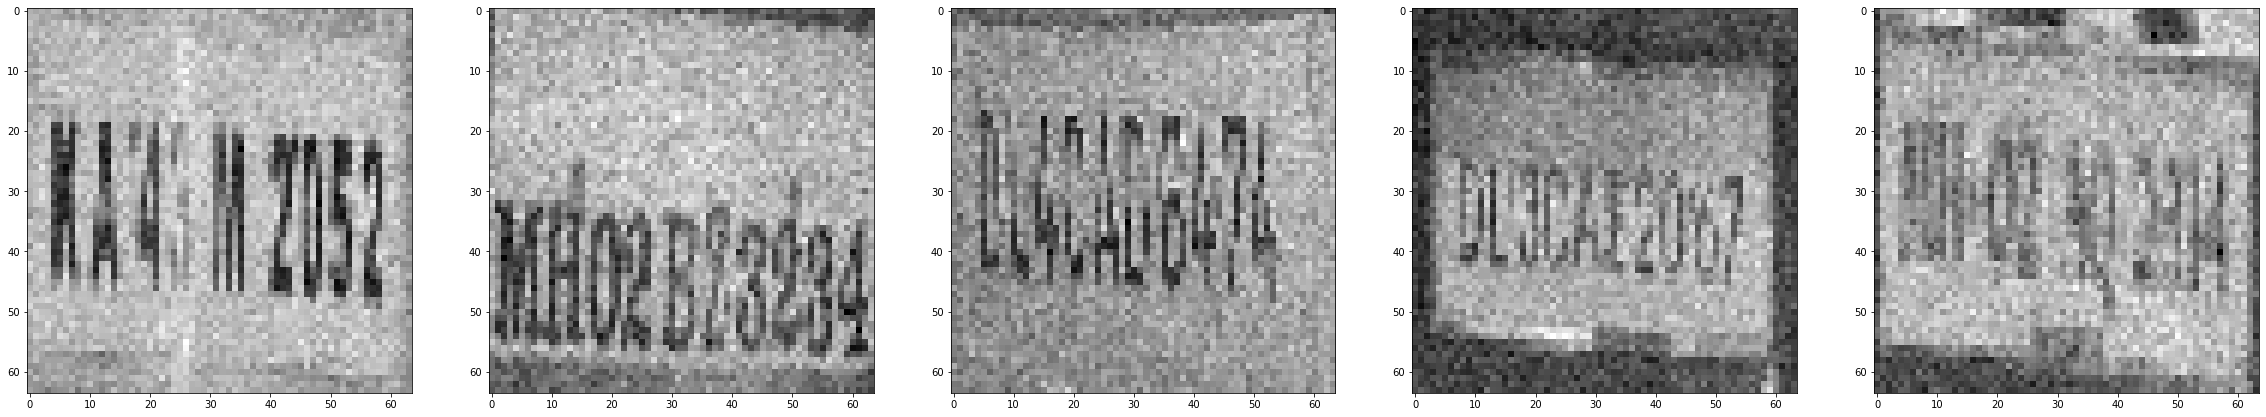

In [31]:
show_img(noised_df)

In [32]:
noised_df.shape

(1182, 64, 64, 1)

In [33]:
train_df.shape

(1182, 64, 64, 1)

In [34]:
xnoised= noised_df[0:100]
xtest= noised_df[100:]

In [35]:
xnoised.shape

(100, 64, 64, 1)

### Defining the model architecture as per the design suggested in the paper

In [36]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K

def autoencoder():
    
    input_img = Input(shape=(64,64,1), name='image_input')
    
    #enoder 
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

In [37]:
model= autoencoder()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 64, 64, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 64, 64, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 64)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 64)        36928     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
upsample1 (UpSampling2D)     (None, 32, 32, 64)        0   

In [38]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    model.fit(xnoised, xnoised, epochs=100, batch_size=10, validation_data=(xtest, xtest), callbacks=[early_stopping])

Epoch 1/100
10/10 [==============================] - 0s 49ms/step - loss: 0.6574 - val_loss: 0.6497
Epoch 2/100
10/10 [==============================] - 0s 39ms/step - loss: 0.6185 - val_loss: 0.6081
Epoch 3/100
10/10 [==============================] - 0s 33ms/step - loss: 0.5937 - val_loss: 0.5976
Epoch 4/100
10/10 [==============================] - 0s 33ms/step - loss: 0.5849 - val_loss: 0.5859
Epoch 5/100
10/10 [==============================] - 0s 32ms/step - loss: 0.5781 - val_loss: 0.5816
Epoch 6/100
10/10 [==============================] - 0s 30ms/step - loss: 0.5728 - val_loss: 0.5765
Epoch 7/100
10/10 [==============================] - 0s 31ms/step - loss: 0.5702 - val_loss: 0.5746
Epoch 8/100
10/10 [==============================] - 0s 30ms/step - loss: 0.5670 - val_loss: 0.5725
Epoch 9/100
10/10 [==============================] - 0s 30ms/step - loss: 0.5655 - val_loss: 0.5720
Epoch 10/100
10/10 [==============================] - 0s 34ms/step - loss: 0.5654 - val_loss: 0.5700

In [40]:
xtrain= train_df[100:]

## Plotting the predictions.

### First row:   Original image
### Second row:  Noice image
### Third row:   Denoised image using Autoencoder
### Fourth row:  Median filter image

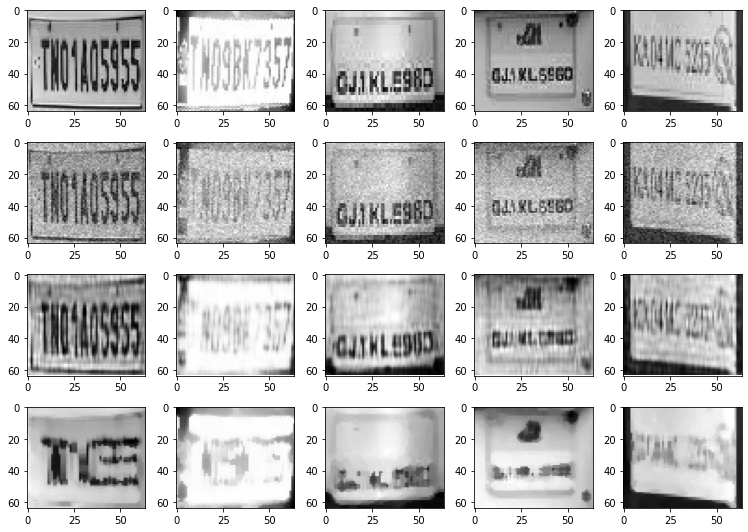

In [41]:
pred= model.predict(xtest[:5])
def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(4, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(xtrain[i], (64,64)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_true[i], (64,64)), aspect='auto', cmap='gray')
        ax[2][i].imshow(np.reshape(y_pred[i], (64,64)), aspect='auto', cmap='gray')
        ax[3][i].imshow(cv2.medianBlur(xtrain[i], (5)), aspect='auto', cmap='gray')
       
    plt.tight_layout()
plot_predictions(xtest[:5], pred[:5])

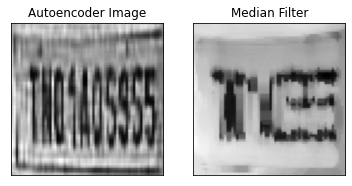

In [42]:
new_image = cv2.medianBlur(xtrain[0], (5))
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.imshow(pred[0].reshape(64,64), cmap='gray')
plt.title('Autoencoder Image')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(new_image, cmap='gray')
plt.title('Median Filter')
plt.xticks([])
plt.yticks([])
plt.show()

In [43]:
from math import log10, sqrt 
  
def PSNR(original, denoiced): 
    mse = np.mean((original - denoiced) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 
  
value1 = PSNR(xtest[0], new_image)
value2 = PSNR(xtest[0], pred[0])

print(f"PSNR value for Denoised image is {value2} dB while for Median filtered image is {value1} dB")

PSNR value for Denoised image is 69.21101217021805 dB while for Median filtered image is 61.91361043516203 dB


In [44]:
test_images = sorted(os.listdir('/kaggle/input/test123'))

In [45]:
test_image = []
for im in test_images:
    img = image.load_img('/kaggle/input/test123/'+ im, target_size=(64,256), color_mode= 'grayscale')
    img = image.img_to_array(img)
    img = img/255
    test_image.append(img)
test_df = np.array(test_image)

In [46]:
pred= model.predict(test_df)

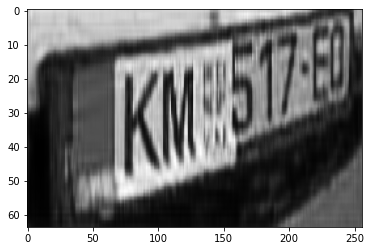

In [47]:
plt.imshow(np.reshape(pred[2], (64,256)), aspect='auto', cmap='gray')

In [48]:
blur = cv2.GaussianBlur(pred[2], (5,5), 0)
smooth = cv2.addWeighted( blur, 3, pred[2], -0.5, 2)

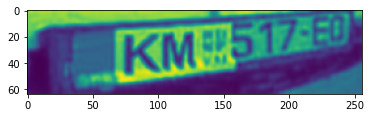

In [49]:
plt.imshow(blur)

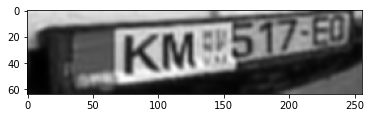

In [50]:
plt.imshow(smooth, cmap='gray')

In [51]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array
import functools

In [52]:
# Read the image and convert to grayscale
image = cv2.imread("/kaggle/input/test123/Sample2.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [53]:
# Apply Gaussian blurring and thresholding 
# to reveal the characters on the license plate
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blurred, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 45, 15)

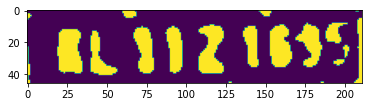

In [54]:
plt.imshow(thresh)